In [4]:
import sys
import os

sys.path.append("../")

In [137]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import CharacterTextSplitter


from langchain_chroma import Chroma
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper


from langchain_nomic.embeddings import NomicEmbeddings

import yaml

from typing import List
from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from typing import Literal, Optional


# Global Variable

In [138]:
POLITICAL_PARTI = "nFP" # RN / nFP / Ren
PDF_ROOT = "../data/raw/{}/".format(POLITICAL_PARTI)

In [195]:
MODEL_GRADER = "phi3:medium"
YAML_GRADER_PATH = "../prompts/grader_prompt.yaml"

MODEL_CRITICS = "nous-hermes2:10.7b"
YAML_CRITICS_PATH = "../prompts/criticer_prompt.yaml"

MODEL_QUERY_RAG_REWRITER = "openhermes"
YAML_QUERY_RAG_REWRITER_PATH = "../prompts/q_rewrite_rag_prompt.yaml"

MODEL_QUERY_WEB_REWRITER = "openhermes"
YAML_QUERY_WEB_REWRITER_PATH = "../prompts/q_rewrite_websearch_prompt.yaml"

MODEL_GENERATOR = "nous-hermes2:10.7b"
YAML_GENERATOR_PATH = "../prompts/generate_prompt.yaml"

MODEL_SUMMARY = "nous-hermes2:10.7b"
YAML_SUMMARY_PATH = "../prompts/resume_prompt.yaml"

# Def

In [140]:
def load_yaml_file(file_path):
    try:
        with open(file_path) as stream:
            data = yaml.safe_load(stream)
            return data
    except yaml.YAMLError as exc:
        print(f"Error loading YAML: {exc}")
        return None

In [141]:
def create_chain(model:str, 
                 model_output_format:str,
                 model_temp:int,
                 yaml_file:str, 
                 yaml_var_name:str,
                 format_dict:dict, 
                 parser,
                 ):
    
    prompt = load_yaml_file(yaml_file)[yaml_var_name]

    llm = ChatOllama(model=model, 
                            format=model_output_format, 
                            temperature=model_temp,)

    prompt = ChatPromptTemplate.from_messages([
        ("system", prompt['sys']),
        ("user", prompt['user'])
    ])

    if parser:
        chain = prompt | llm | parser
    else:
        chain = prompt | llm

    return chain.invoke(format_dict)

In [142]:
def load_chunk_persist_pdf(root=PDF_ROOT) -> Chroma : 
    documents = []
    for file in os.listdir(root):
            if file.endswith('.pdf'):
                pdf_path = os.path.join(root+file)
                loader = PyPDFLoader(pdf_path)
                documents.extend(loader.load())
    text_splitter = CharacterTextSplitter(chunk_size=40, chunk_overlap=10)
    # split it into chunks
    docs = text_splitter.split_documents(documents)
         
    vectorstore = Chroma.from_documents(documents =docs,
                                collection_name="rag-chroma",
                                embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                                inference_mode='local'),
                                )
    
    retriever = vectorstore.as_retriever()

    return retriever

# Load and Vectorize

## Multiple pdf loading

In [143]:
retriever = load_chunk_persist_pdf()

## Load one txt file for RN and Ren

In [144]:
'''# Build the RAG
loader = TextLoader("../data/raw/{partie}/{partie}.txt".format(partie=POLITICAL_PARTI))
documents = loader.load()

# split it into chunks
docs = text_splitter.split_documents(documents)

# load it into Chroma
vectorstore = Chroma.from_documents(documents =docs,
                            collection_name="rag-chroma",
                            embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                            inference_mode='local'),
                            )
retriever = vectorstore.as_retriever()'''

'# Build the RAG\nloader = TextLoader("../data/raw/{partie}/{partie}.txt".format(partie=POLITICAL_PARTI))\ndocuments = loader.load()\n\n# split it into chunks\ndocs = text_splitter.split_documents(documents)\n\n# load it into Chroma\nvectorstore = Chroma.from_documents(documents =docs,\n                            collection_name="rag-chroma",\n                            embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",\n                            inference_mode=\'local\'),\n                            )\nretriever = vectorstore.as_retriever()'

# Fonction in Graph

## NODE

In [145]:
### Retrieve RAG #### 

def retrieve(state):
    print("---RETRIEVE---")

    question = state["question"]
    memory = state["memory"]
    documents = retriever.invoke(question)

    return {"documents": documents, "question": question, "memory":memory}

In [146]:
class EvaluationResult(BaseModel):
    Result: Literal['Yes', 'No']
    Explanation: Optional[str] = Field(None, description="Explanation if No")

In [147]:
#### Grader Rag ####
def grade_rag(state):
    print("---GRADE RAG---")

    question = state["question"]
    documents = state["documents"]
    memory=state["memory"]

    parser = PydanticOutputParser(pydantic_object=EvaluationResult)

    grader_dict = {
        "documents": documents,
        "question": question,
        "json_formating": parser.get_format_instructions(), 
        "memory":memory
    }

    critics_grader_chain = create_chain(model=MODEL_GRADER, 
                                        model_output_format='json',
                                        model_temp=0.3,
                                        yaml_file=YAML_GRADER_PATH, 
                                        yaml_var_name="Template",
                                        format_dict=grader_dict, 
                                        parser=parser)
    
    grade = critics_grader_chain.Result

    if grade.lower() == "yes":
            print("---GRADE: RAG RELEVANT---")
            rewrite = "No"
    else:
        print("---GRADE: RAG NOT RELEVANT---")
        # We do not include the document in filtered_docs
        # We set a flag to indicate that we want to run web search
        rewrite = "Yes"  

    return {"documents": documents, "question": question, "rewrite": rewrite, "memory":memory}

In [148]:
#### Question Re-writer RAG ####
def rewrite_rag_q(state):
    print("---REWRITE QUESTION FOR RAG---")

    question = state["question"]
    documents = state["documents"]
    memory=state["memory"]

    grader_dict = {
        "question": question,
    }

    rewrite_question_invole = create_chain(model=MODEL_QUERY_RAG_REWRITER, 
                                        model_output_format=None,
                                        model_temp=0.3,
                                        yaml_file=YAML_QUERY_RAG_REWRITER_PATH, 
                                        yaml_var_name="Template",
                                        format_dict=grader_dict, 
                                        parser=StrOutputParser())
    
    return {"question":rewrite_question_invole, "memory":memory}

In [149]:
#### Web Search ####
search_wrapper = DuckDuckGoSearchAPIWrapper(region="fr-fr", time="w", max_results=3)
#search = DuckDuckGoSearchResults(api_wrapper=wrapper)

def web_search(state):

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    web_docs = state["web_docs"]
    memory=state["memory"]

    ddg = DuckDuckGoSearchRun()
    web_results = ddg(question)
    
    #docs = search_wrapper.results(question, max_results=3)
    #web_results = "\n".join([d['title'] + "\n" + d['snippet'] for d in docs])

    if web_docs is not None:
        web_docs.append(web_results)
    else:
        web_docs = [web_results]

    return {"documents": documents, "question": question, "web_docs": web_docs, "memory":memory} 


In [150]:
#### Generate ####

def generate(state):
    print("---GENERATE A RESPONSE---")

    question = state["question"]
    documents = state["documents"]
    web_docs = state["web_docs"]
    memory=state["memory"]
        
    generator_dict = {
        "question": question,
        "documents": documents,
        "web_docs": web_docs,
        "memory": memory
    }

    generation = create_chain(model=MODEL_GENERATOR, 
                                        model_output_format=None,
                                        model_temp=0.3,
                                        yaml_file=YAML_GENERATOR_PATH, 
                                        yaml_var_name="Template",
                                        format_dict=generator_dict, 
                                        parser=StrOutputParser())
    
    return {"documents": documents, "question": question, "web_docs": web_docs, "generation": generation, "memory":memory}

In [151]:
###### Critics Grader ######
def grade_generation(state):
    
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    documents = state["documents"]
    question = state["question"]
    web_docs = state["web_docs"]
    generation = state["generation"]
    memory = state["memory"]

    
    parser =  PydanticOutputParser(pydantic_object=EvaluationResult)
    critics_dict = {
        "generation": generation,
        "json_formating": parser.get_format_instructions(),
        "memory":memory,
    }

    grader_chain_invoke = create_chain(model=MODEL_CRITICS, 
                                        model_output_format='json',
                                        model_temp=0.3,
                                        yaml_file=YAML_CRITICS_PATH, 
                                        yaml_var_name="Template",
                                        format_dict=critics_dict, 
                                        parser=parser)
    
    grade = grader_chain_invoke.Result
    
    if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            need_web_search = "No"
    else:
        print("---GRADE: DOCUMENT NOT RELEVANT---")
        # We do not include the document in filtered_docs
        # We set a flag to indicate that we want to run web search
        need_web_search = "Yes"    
        
    return {"documents": documents, "question": question, "web_docs": web_docs, "generation": generation, "memory":memory, "need_web_search": need_web_search}

In [152]:
###### Web Query Writer ######
def rewrite_query_web(state):
    print("---REWRITE QUESTION FOR WEB QUERY---")
    documents = state["documents"]
    question = state["question"]
    memory = state["memory"]

    critics_dict = {
        "question": question,
        "memory": memory
    }

    webquery_chain_invoke = create_chain(model=MODEL_QUERY_WEB_REWRITER, 
                                        model_output_format=None,
                                        model_temp=0.3,
                                        yaml_file=YAML_QUERY_WEB_REWRITER_PATH, 
                                        yaml_var_name="Template",
                                        format_dict=critics_dict, 
                                        parser=StrOutputParser())
    
    return {"documents": documents, "question": webquery_chain_invoke, "memory": memory}
    


## Router

In [153]:
#### DECIDE TO RE_GENERATE OR NOT ####

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["need_web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "rewrite_query_web"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "useful"
    

def decide_to_rag(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    re_rag = state["rewrite"]
    state["documents"]

    if re_rag == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION---"
        )
        return "rewrite_question"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: WEB SEARCH---")
        return "websearch"

In [197]:
## Resume memory LLM

def resume_memory_llm(state:dict)->str:
    print("---IN MEMORY WRITING---")

    question = state["question"]
    generation = state["generation"]
    memory = state["memory"]

    if len(memory) > 1:
        memory = state["memory"]
    else:
        memory = ""
        
    generator_dict = {
        "question": question,
        "generation": generation,
        "memory": memory
    }

    summary_invoke = create_chain(model=MODEL_SUMMARY, 
                            model_output_format=None,
                            model_temp=0,
                            yaml_file=YAML_SUMMARY_PATH, 
                            yaml_var_name="Template",
                            format_dict=generator_dict, 
                            parser=StrOutputParser())
    
    return {"memory":summary_invoke}

# Graph FLow

## Graphe states

In [154]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
        
    """

    question: str
    generation: str
    web_docs: str
    documents: List[str]
    need_web_search: str
    rewrite: str
    memory: str

## Build Graph

In [155]:
from langgraph.graph import END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeColors

In [156]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_rag", grade_rag)# grade_rag
workflow.add_node("rewrite_rag_q", rewrite_rag_q)# rewrite_rag_q
workflow.add_node("web_search", web_search)# web_search
workflow.add_node("generate", generate)# generate
workflow.add_node("grade_generation", grade_generation)# grade_generation
workflow.add_node("rewrite_query_web", rewrite_query_web)# rewrite_query_web



In [157]:
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_rag")
workflow.add_conditional_edges(
    "grade_rag",
    decide_to_rag,
    {
        "rewrite_question":"rewrite_rag_q",
        "websearch":"web_search"
    },
)
workflow.add_edge("rewrite_rag_q", "retrieve")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", "grade_generation")
workflow.add_conditional_edges(
    "grade_generation",
    decide_to_generate,
    {
        "rewrite_query_web":"rewrite_query_web",
        "useful": END,
    }

)
workflow.add_edge("rewrite_query_web", "web_search")

# Compile
app = workflow.compile()

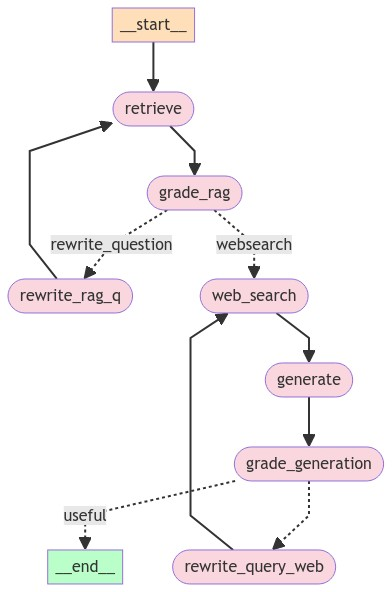

In [158]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [161]:
from pprint import pprint

# Run
inputs = {"question": "Est-ce que le programme économique du front populaire pour les législatives de 2024 est-il viable d'un point de vue économique ?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---GRADE RAG---
---GRADE: RAG RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: WEB SEARCH---
"Node 'grade_rag':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE A RESPONSE---
"Node 'generate':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_generation':"
'\n---\n'
('Le programme économique du Nouveau Front Populaire pour les législatives de '
 "2024 est axé sur trois priorités principales : agir pour le pouvoir d'achat "
 'des Français, engager une bifurcation écologique et réparer et développer '
 'les services publics. Le programme prévoit un investissement total de 106 '
 "milliards d'euros sur trois ans.\n"
 '\n'
 "Pour agir pour le pouvoir d'achat des Français, le Nouveau Front Populaire "
 "prévoit d'investir 90 milliards d'euros dans la réponse à l'urgence sociale. "
 'Cette priorité vise à améliorer les 

In [ ]:
resume_memory_llm(value)

In [160]:
pprint(value["generation"])

('Le programme économique du Nouveau Front Populaire (NFP) pour les élections '
 'législatives se concentre sur trois principales priorités : agir pour le '
 "pouvoir d'achat des Français, réaliser une bifurcation écologique pour "
 'préserver le climat et la vie sauvage, et réparer et développer les services '
 'publics.\n'
 '\n'
 "1. Agir pour le pouvoir d'achat des Français : Le gouvernement du NFP vise à "
 'améliorer la situation économique des Français en augmentant leur pouvoir '
 "d'achat. Pour cela, ils souhaitent mettre en place une politique économique "
 'vertueuse qui favoriserait les classes populaires et moyennes. Ce serait '
 'réalisé par une réduction de la fiscalité pour les revenus inférieurs à 2500 '
 '€, un salaire minimum garanti à 1 800 € brut mensuel, et une augmentation '
 'des allocations familiales.\n'
 '\n'
 '2. Une bifurcation écologique pour préserver le climat et la vie sauvage : '
 "Le NFP s'engage à réaliser une transformation profonde de nos modes de "